In [1]:
# import nstrace
import sys
import matplotlib.pyplot as plt
import matplotlib

In [2]:
filename = 'trace.tr'
with open(filename) as f:
    content = f.readlines()

In [3]:
splitter = lambda x: x.split()
split_list = list(map(splitter, content))

In [4]:
keep_cwnd = lambda x: x if 'cwnd_' in x else None
just_cwnd = list(map(keep_cwnd, split_list))

In [5]:
just_cwnd = list(filter((None).__ne__, just_cwnd))

In [6]:
data_maker = lambda x: [x[0], x[1], x[3], x[6]]
data = list(map(data_maker, just_cwnd))

In [7]:
stream_1_maker = lambda x: x if x[1] == '0' and x[2] == '4' else None
stream_1 = list(map(stream_1_maker, data))
stream_1 = list(filter((None).__ne__, stream_1))

stream_2_maker = lambda x: x if x[1] == '1' and x[2] == '5' else None
stream_2 = list(map(stream_2_maker, data))
stream_2 = list(filter((None).__ne__, stream_2))

In [8]:
print(len(stream_1), len(stream_2))

486 454


***

In [9]:
cwnd_file = 'cwnd'
with open(cwnd_file) as f:
    content = f.readlines()
splitter = lambda x: x[:-1].split()
split_cwnd = list(map(splitter, content))

In [10]:
time = list(map(lambda x: x[0], split_cwnd))
cwnd1 = list(map(lambda x: x[1], split_cwnd))
cwnd2 = list(map(lambda x: x[2], split_cwnd))

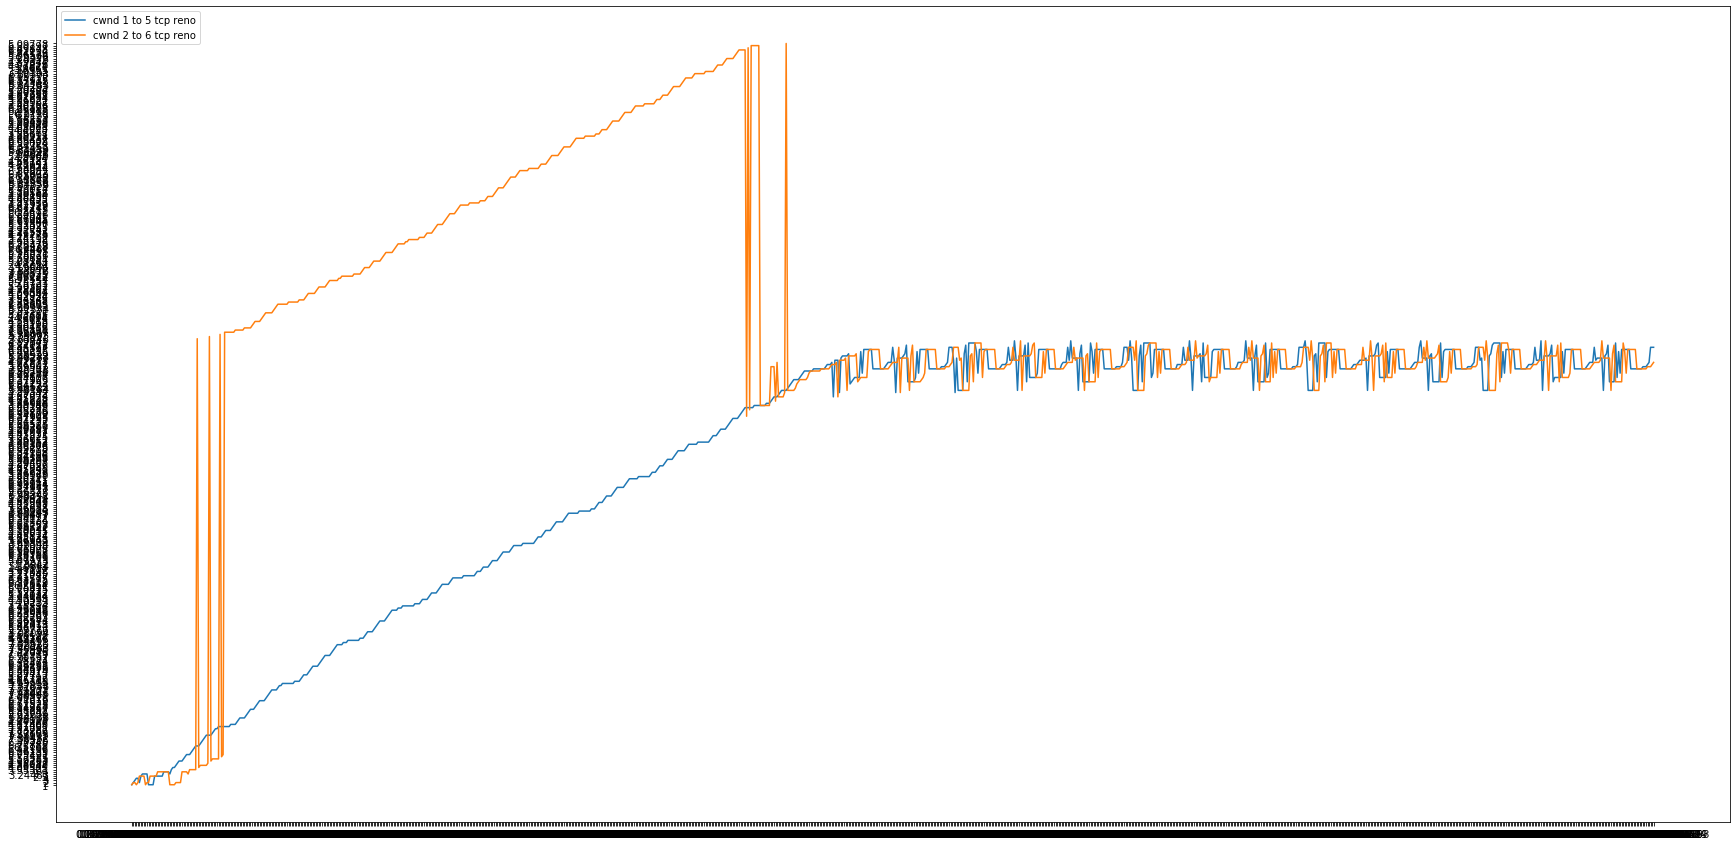

In [11]:
plt.figure(figsize=(30,15))
plt.plot(time, cwnd1)
plt.plot(time, cwnd2)
plt.legend(['cwnd 1 to 5 tcp reno', 'cwnd 2 to 6 tcp reno'], loc='upper left')
plt.show()

In [12]:
rtt_file = 'rtt'
with open(rtt_file) as f:
    content = f.readlines()
splitter = lambda x: x[:-1].split()
split_rtt = list(map(splitter, content))

time = list(map(lambda x: x[0], split_rtt))
rtt1 = list(map(lambda x: x[1], split_rtt))
rtt2 = list(map(lambda x: x[2], split_rtt))

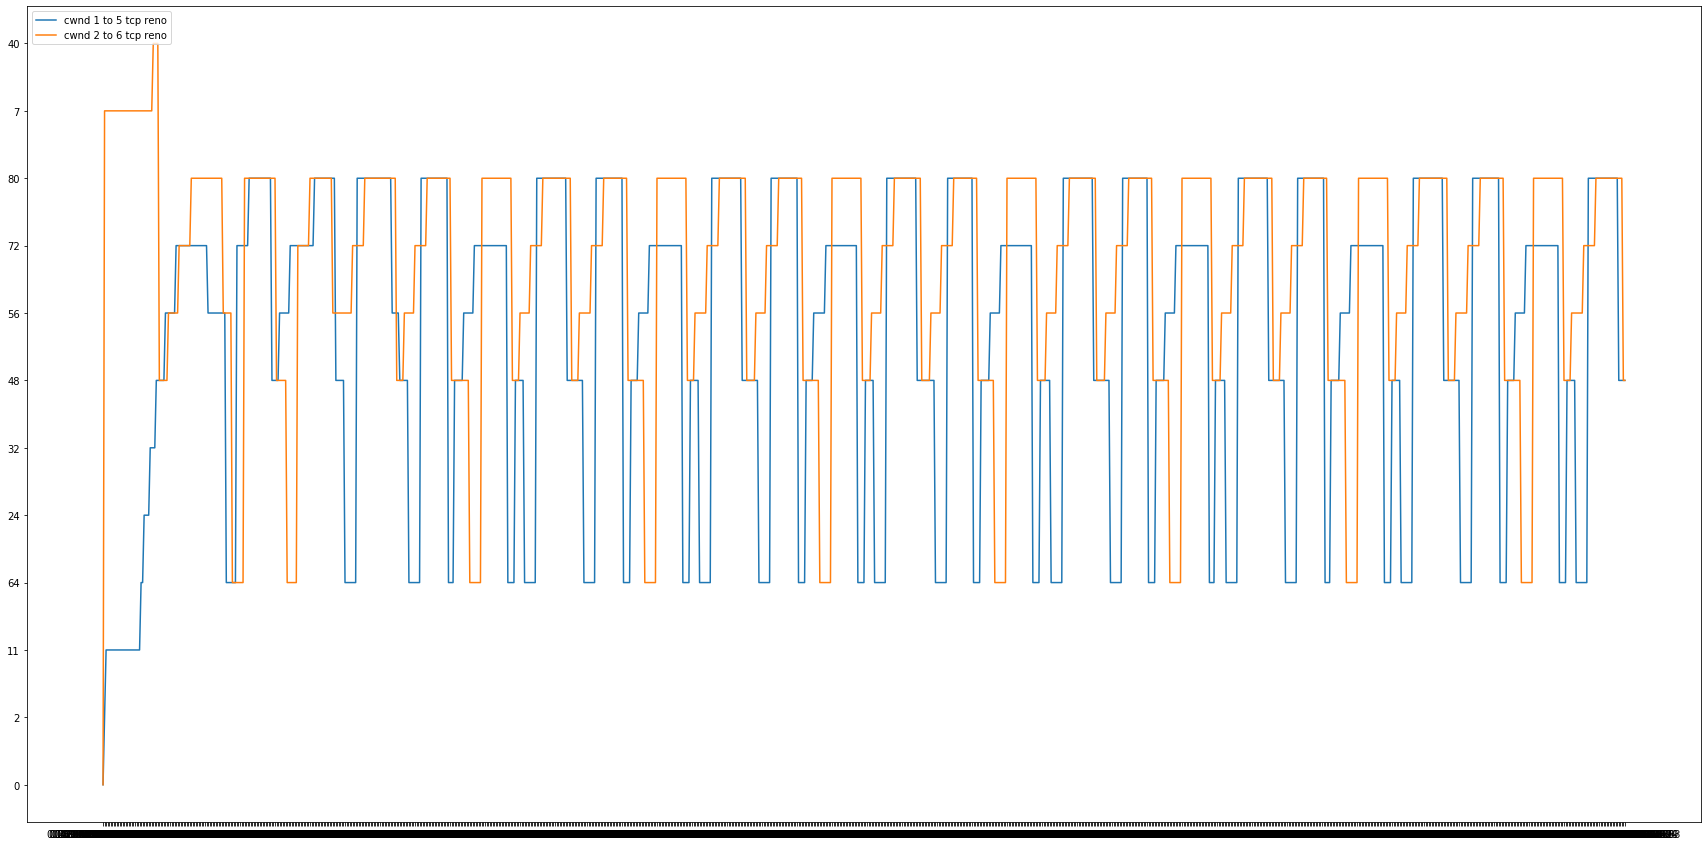

In [13]:
plt.figure(figsize=(30,15))
plt.plot(time, rtt1)
plt.plot(time, rtt2)
plt.legend(['cwnd 1 to 5 tcp reno', 'cwnd 2 to 6 tcp reno'], loc='upper left')
plt.show()

In [33]:
filename = 'trace.tr'
with open(filename) as f:
    content = f.readlines()
split_drop = list(map(lambda x: x[:-1].split(), content))
drop_data = list(map(lambda x: x if 'd' in x else None, split_drop))
drop_data = list(filter((None).__ne__, drop_data))

drop_1 = list(map(lambda x: [x[1]] if x[7] == '0' else None, drop_data))
drop_1 = list(filter((None).__ne__, drop_1))

drop_2 = list(map(lambda x: [x[1]] if x[7] == '1' else None, drop_data))
drop_2 = list(filter((None).__ne__, drop_2))

print(len(drop_1))
print(len(drop_2))

26
27


In [34]:
split_packet = list(map(lambda x: x[:-1].split(), content))
packet_data = list(map(lambda x: x if '+' in x else None, split_packet))
packet_data = list(filter((None).__ne__, packet_data))

packet_1 = list(map(lambda x: [x[1]] if x[2] == '0' and x[3] == '2' else None, packet_data))
packet_1 = list(filter((None).__ne__, packet_1))

packet_2 = list(map(lambda x: [x[1]] if x[2] == '1' and x[3] == '2' else None, packet_data))
packet_2 = list(filter((None).__ne__, packet_2))

print(len(packet_1))
print(len(packet_2))

675
636
